# Regression Part 2:
## Debut Releases

In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn import feature_selection as f_select
from sklearn.cross_validation import cross_val_score
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from datetime import datetime as dt
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
sns.set_palette("RdBu", n_colors=7)
%pylab inline

import warnings
warnings.filterwarnings('ignore')

/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Sections

### Load the pickled dataframe

In [6]:
with open("review2_2_df.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [7]:
len(df)

18218

In [ ]:
#df.head()

In [8]:
df.drop(df[df.release_number > 1].index, inplace=True)

In [9]:
len(df)

8703

In [10]:
df.describe()

,score,word_count,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
count,8703.000000,8703.000000,8703.000000,8703.000000,8703.0,0.0,8703.000000,8441.000000,7887.000000
mean,6.991233,627.688498,221.574974,2.093301,1.0,NaN,101.234632,6.969006,33.223532
std,1.278518,208.095632,212.521965,2.063134,0.0,NaN,130.536191,0.500563,22.515801
min,0.000000,11.000000,1.000000,1.000000,1.0,NaN,1.000000,3.800000,0.000000
25%,6.500000,490.000000,53.000000,1.000000,1.0,NaN,16.000000,6.668750,14.000000
50%,7.300000,588.000000,151.000000,1.000000,1.0,NaN,49.000000,7.023264,32.000000
75%,7.800000,717.000000,284.000000,2.000000,1.0,NaN,137.000000,7.310784,50.000000
max,10.000000,2834.000000,727.000000,34.000000,1.0,NaN,726.000000,9.750000,100.000000


<a id'Data Preprocessing'></a>
# Data Preprocessing

Add a column "year"

In [11]:
df["year"] = df["pub_date_x_x"].dt.year

In [12]:
df.year.describe()

count    8703.000000
mean     2008.451109
std         4.990210
min      1999.000000
25%      2004.000000
50%      2008.000000
75%      2013.000000
max      2017.000000
Name: year, dtype: float64

In [13]:
year_bins = [0, 2004, 2009, 2014, 2017]

In [14]:
year_groups = ['1999-2004', '2005-2009', '2010-2014', '2015-2017']

In [15]:
df['year_binned'] = pd.cut(df['year'], year_bins, labels=year_groups)

In [ ]:
#df.head()

### Drop columns which do not apply for debut releases

__Spotify popularity should not factor in for a debut release__

--> drop column

In [16]:
df.drop('spotify_popularity', axis=1, inplace=True)

__Cumulative mean score (artist) is n/a for a debut release__

In [17]:
df.drop('cum_mean_score', axis=1, inplace=True)

### Fill in missing values

__Cumulative mean score (author)__

Change all "NaN" to mean cum score

In [18]:
len(df.loc[df.cum_mean_score_author.isnull()])

262

In [19]:
df.cum_mean_score_author.fillna(df.cum_mean_score_author.mean(), inplace=True)

In [ ]:
#df.loc[df['author_review_count'] == 1].head()


__Double check that we haven't missed any "NaN" values:__

In [20]:
df.isnull().values.any()

False

### Start exploring the data

In [21]:
len(df)

8703

In [22]:
df.describe()

,score,word_count,year,author_review_count,total_number_releases,release_number,review_number,cum_mean_score_author
count,8703.000000,8703.000000,8703.000000,8703.000000,8703.000000,8703.0,8703.000000,8703.000000
mean,6.991233,627.688498,2008.451109,221.574974,2.093301,1.0,101.234632,6.969006
std,1.278518,208.095632,4.990210,212.521965,2.063134,0.0,130.536191,0.492970
min,0.000000,11.000000,1999.000000,1.000000,1.000000,1.0,1.000000,3.800000
25%,6.500000,490.000000,2004.000000,53.000000,1.000000,1.0,16.000000,6.687596
50%,7.300000,588.000000,2008.000000,151.000000,1.000000,1.0,49.000000,7.008824
75%,7.800000,717.000000,2013.000000,284.000000,2.000000,1.0,137.000000,7.302778
max,10.000000,2834.000000,2017.000000,727.000000,34.000000,1.0,726.000000,9.750000


### Look at some histograms:

__Score__

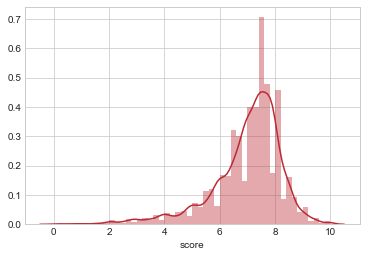

In [23]:
sns.distplot(df.score);

__[SKIP] Spotify popularity__

In [ ]:
#sns.distplot(df.spotify_popularity);

__Word count__

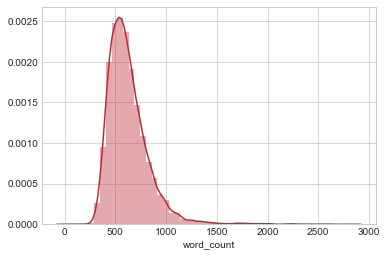

In [24]:
sns.distplot(df.word_count);

__Year__

In [ ]:
sns.distplot(df.year);

### Initial look at correlation between features

In [25]:
df.corr()

,score,word_count,year,author_review_count,total_number_releases,release_number,review_number,cum_mean_score_author
score,1.000000,0.176306,0.059675,-0.000960,0.144099,NaN,0.025261,0.376689
word_count,0.176306,1.000000,0.079568,0.003252,0.081779,NaN,0.046186,0.126625
year,0.059675,0.079568,1.000000,-0.020395,-0.342470,NaN,0.259530,0.076083
author_review_count,-0.000960,0.003252,-0.020395,1.000000,-0.059738,NaN,0.729674,-0.071171
total_number_releases,0.144099,0.081779,-0.342470,-0.059738,1.000000,NaN,-0.115369,0.024234
release_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_number,0.025261,0.046186,0.259530,0.729674,-0.115369,NaN,1.000000,-0.024654
cum_mean_score_author,0.376689,0.126625,0.076083,-0.071171,0.024234,NaN,-0.024654,1.000000


In [26]:
df.corr().score.sort_values(ascending=False)

score                    1.000000
cum_mean_score_author    0.376689
word_count               0.176306
total_number_releases    0.144099
year                     0.059675
review_number            0.025261
author_review_count     -0.000960
release_number                NaN
Name: score, dtype: float64

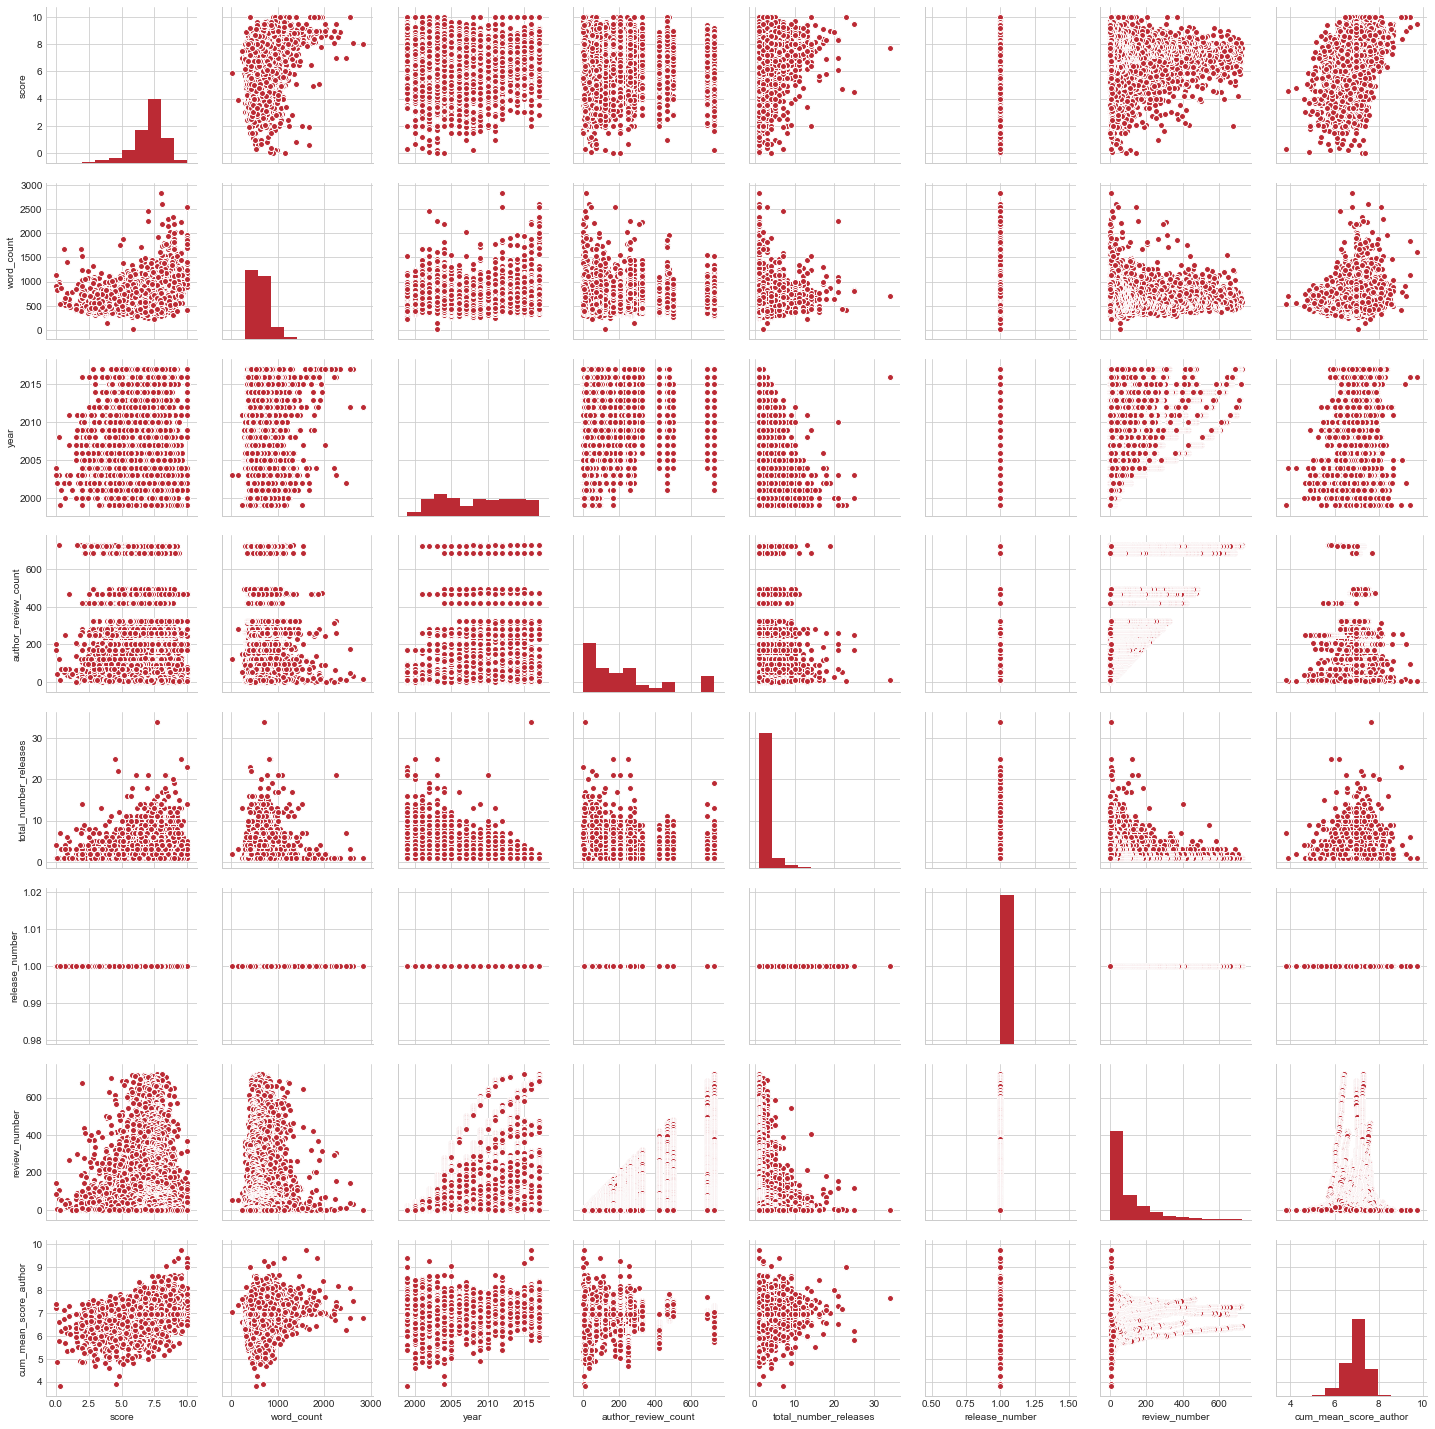

In [27]:
sns.pairplot(df);

### Look at correlations individually

In [ ]:
# N/A for this df
#df.plot(kind='scatter', x='cum_mean_score', y='score');

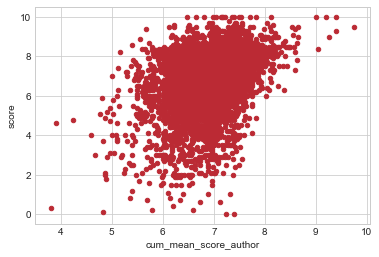

In [28]:
df.plot(kind='scatter', x='cum_mean_score_author', y='score');

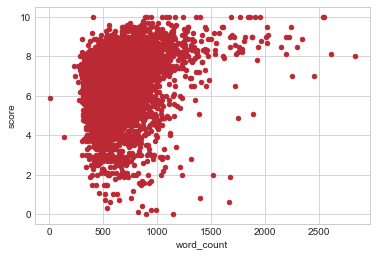

In [29]:
df.plot(kind='scatter', x='word_count', y='score');

In [ ]:
# N/A for this df
#df.plot(kind='scatter', x='total_number_releases', y='score');

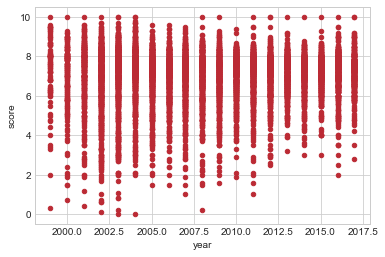

In [30]:
df.plot(kind='scatter', x='year', y='score');

In [ ]:
#df.plot(kind='scatter', x='release_number', y='score');

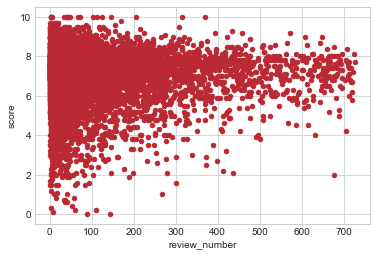

In [31]:
df.plot(kind='scatter', x='review_number', y='score');

In [ ]:
# N/A for this df
#df.plot(kind='scatter', x='spotify_popularity', y='score');

### Create dummy variables from categorical variables

__[SKIP] Best New Music / Best New Reissue__

Note: I later decided NOT to include this feature since "best new music" is likely to be assigned AFTER a score is given.

In [ ]:
#df['best'] = np.where(df['bnm'] != 'None', 1.0, 0.0)

In [ ]:
#df.loc[df['bnm'] == "None"]

In [ ]:
#df = df.drop('best', axis=1)

__Record labels__

Sub Pop is the label with the most number of releases that have been reviewed by Pitchfork.  It is also claimed that Pitchfork favours this label over others.

In [32]:
df.label.value_counts(ascending=False).head()

Self-released    215
Sub Pop           97
Thrill Jockey     90
Drag City         89
Interscope        75
Name: label, dtype: int64

In [33]:
df['subpop'] = np.where(df['label'] == 'Sub Pop', 1.0, 0.0)

Pitchfork is big on independent music

In [34]:
df['self_released'] = np.where(df['label'] == 'Self-released', 1.0, 0.0)

In [ ]:
#df.loc[df['label'] == "Sub Pop"]

__Genre__

In [35]:
df.genre.value_counts(ascending=False)

Rock            2725
Electronic      1808
None            1328
Experimental     672
Pop/R&B          642
Rap              574
Metal            376
Folk/Country     327
Jazz             156
Global            95
Name: genre, dtype: int64

In [36]:
X_genre = patsy.dmatrix('genre', data=df, return_type='dataframe')

In [37]:
X_genre.head()

,Intercept,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],genre[T.Jazz],genre[T.Metal],genre[T.None],genre[T.Pop/R&B],genre[T.Rap],genre[T.Rock]
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df = df.join(X_genre)

In [39]:
df['genre[T.Electronic]'] = np.where(df['genre'] == 'Electronic', 1.0, 0.0)

In [ ]:
#df.head()

__Author title__

In [40]:
df.author_title.value_counts(ascending=False)

Contributor                  5892
None                         1903
Contributing Editor           260
Senior Staff Writer           201
Executive Editor              167
Senior Editor                  56
Deputy News Editor             46
Tracks Coordinator             37
Editor-in-Chief                31
Associate Staff Writer         28
Contributing Writer            27
Associate Reviews Editor       25
Assistant Editor               14
Associate Editor               10
Managing Editor                 5
Associate Features Editor       1
Name: author_title, dtype: int64

In [41]:
df['title[T.Contributor]'] = np.where(df['author_title'] == 'Contributor', 1.0, 0.0)

In [42]:
df['title[T.Contributing_Editor]'] = np.where(df['author_title'] == 'Contributing Editor', 1.0, 0.0)

In [43]:
df['title[T.Executive_Editor]'] = np.where(df['author_title'] == 'Executive Editor', 1.0, 0.0)

In [44]:
df['title[T.Senior_Staff_Writer]'] = np.where(df['author_title'] == 'Senior Staff Writer', 1.0, 0.0)

In [ ]:
#df['title[T.Senior_Editor]'] = np.where(df['author_title'] == 'Senior Editor', 1.0, 0.0)

__Year_binned__

In [45]:
df.year_binned.value_counts(ascending=False)

2005-2009    2531
1999-2004    2450
2010-2014    2355
2015-2017    1367
Name: year_binned, dtype: int64

In [46]:
df['1999-2004'] = np.where(df['year_binned'] == '1999-2004', 1.0, 0.0)

In [47]:
df['2005-2009'] = np.where(df['year_binned'] == '2005-2009', 1.0, 0.0)

In [48]:
df['2010-2014'] = np.where(df['year_binned'] == '2010-2014', 1.0, 0.0)

In [49]:
df['2015-2017'] = np.where(df['year_binned'] == '2015-2017', 1.0, 0.0)

### Have another look at correlations

In [ ]:
#df.corr()

In [50]:
df.corr().score.sort_values(ascending=False)

score                           1.000000
cum_mean_score_author           0.376689
word_count                      0.176306
total_number_releases           0.144099
genre[T.Experimental]           0.079156
year                            0.059675
2015-2017                       0.059228
title[T.Contributing_Editor]    0.054103
genre[T.Jazz]                   0.052545
title[T.Contributor]            0.046620
genre[T.Global]                 0.039817
title[T.Executive_Editor]       0.035878
genre[T.Folk/Country]           0.026783
2010-2014                       0.026653
review_number                   0.025261
genre[T.Electronic]             0.002182
subpop                         -0.000214
author_review_count            -0.000960
self_released                  -0.003135
genre[T.Rap]                   -0.006289
genre[T.Metal]                 -0.006677
1999-2004                      -0.015612
genre[T.None]                  -0.031057
genre[T.Pop/R&B]               -0.031692
genre[T.Rock]   

In [51]:
df.columns

Index(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'word_count', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'release_number', 'review_number',
       'cum_mean_score_author', 'year_binned', 'subpop', 'self_released',
       'Intercept', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]', 'genre[T.None]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

## Begin modeling...
### First, define y and X

__Keep: word count, binned year, cum mean score author, subpop, genres, author title....__

In [52]:
y = df.score
x = df.drop(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'release_number', 'year_binned', 
       'Intercept', 'genre[T.None]'],1)

In [53]:
x.columns

Index(['word_count', 'review_number', 'cum_mean_score_author', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

In [54]:
x.head()

,word_count,review_number,cum_mean_score_author,subpop,self_released,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],genre[T.Jazz],genre[T.Metal],...,genre[T.Rock],genre[T.Electronic],title[T.Contributor],title[T.Contributing_Editor],title[T.Executive_Editor],title[T.Senior_Staff_Writer],1999-2004,2005-2009,2010-2014,2015-2017
1,2304,4,8.175000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1091,255,7.550781,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1027,475,7.116000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12,627,56,7.410714,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15,581,280,7.485357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
X = preprocessing.normalize(x, axis=0, norm='max')
X = pd.DataFrame(X)
X.columns = x.columns

Do not need to normalize y since it is normally distributed.

In [56]:
X.columns

Index(['word_count', 'review_number', 'cum_mean_score_author', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

In [57]:
X.head()

,word_count,review_number,cum_mean_score_author,subpop,self_released,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],genre[T.Jazz],genre[T.Metal],...,genre[T.Rock],genre[T.Electronic],title[T.Contributor],title[T.Contributing_Editor],title[T.Executive_Editor],title[T.Senior_Staff_Writer],1999-2004,2005-2009,2010-2014,2015-2017
0,0.812985,0.005510,0.838462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.384968,0.351240,0.774439,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.362385,0.654270,0.729846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.221242,0.077135,0.760073,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.205011,0.385675,0.767729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Baseline R2

In [58]:
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

0.16713322987416168

__Try dropping a few features that were negatively correlated__

In [59]:
X.columns

Index(['word_count', 'review_number', 'cum_mean_score_author', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

In [60]:
X2 = X.drop(['subpop', 'self_released', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'title[T.Senior_Staff_Writer]', '1999-2004',
       '2005-2009'],1)

In [ ]:
X2.columns

In [61]:
baseline2 = LinearRegression()
baseline2.fit(X2,y)
baseline2.score(X2,y)

0.16424490862905494

In [63]:
# model1 = sm.OLS(y, X2)
# fit1 = model1.fit()
# fit1.summary()

## Test-train split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model_tt= LinearRegression()
model_tt.fit(X_train,y_train)

print(f"train R2: {model_tt.score(X_train,y_train)}, "
      f"test R2: {model_tt.score(X_test,y_test)}")

train R2: 0.16387695202014674, test R2: 0.1705845941204578


## Cross validation

In [ ]:
alpha = 0.05

sig_cols = [
    c for c in X.columns
    if f_select.f_regression(X[[c]], y)[1][0] < alpha
]

X_sig = X[sig_cols]

In [ ]:
sig_cols

In [ ]:
est_cv = LinearRegression()
cross_val_score(est_cv, X_sig, y, cv=5, scoring="r2").mean()

__Features selection function:__

In [65]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)

    return sig_cols

In [66]:
kf = KFold(n=len(X), n_folds=5, shuffle=True)
est_cv2 = LinearRegression()

all_scores = []

for train_i, test_i in kf:
    x_train = X.iloc[train_i]
    y_train = y.iloc[train_i].reshape(-1, 1)
    x_test = X.iloc[test_i]
    y_test = y.iloc[test_i].reshape(-1, 1)

    sig_cols = find_sig_cols(x_train, y_train)
    est_cv2.fit(x_train[sig_cols], y_train)
    r2 = est_cv2.score(x_test[sig_cols], y_test)
    all_scores.append(r2)

np.mean(all_scores)

0.15958119041983493

In [67]:
sig_cols

['word_count',
 'review_number',
 'cum_mean_score_author',
 'genre[T.Experimental]',
 'genre[T.Global]',
 'genre[T.Jazz]',
 'genre[T.Pop/R&B]',
 'genre[T.Rock]',
 'title[T.Contributor]',
 'title[T.Contributing_Editor]',
 'title[T.Executive_Editor]',
 'title[T.Senior_Staff_Writer]',
 '2005-2009',
 '2010-2014',
 '2015-2017']

## Regularization

### Ridge regression

In [69]:
est_r1 = Ridge()
est_r1.fit(X_train, y_train)
est_r1.score(X_test, y_test)

0.12177931672433351

In [70]:
est_r1.coef_

array([  8.48065776e-04,   1.73571401e-04,   9.95579351e-01,
         9.02915431e-02,   1.30514383e-01,   3.24844857e-01,
         3.09715081e-01,   3.20565952e-01,   3.38498440e-01,
         3.42660544e-02,   1.11926936e-01,   1.37025869e-01,
         1.90209701e-01,   1.45081216e-01,  -5.58870204e-03,
        -1.82534579e-01,  -9.69720939e-02,   2.02378171e-01,
        -8.25548313e-02,  -1.29019417e-02,   1.12315825e-01,
        -1.68590518e-02])

In [ ]:
zipped = list(zip(list(X_train.columns), est_r1.coef_))
features = sorted(zipped, key=lambda t: t[1], reverse=True)
features

In [71]:
rcv = RidgeCV(alphas=(0.1, 1.0, 10.0, 0.0, 1e-8, 1e-5, 1e-1),cv=10)
r = rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.12212810348026037

In [72]:
rcv.alpha_

10.0

## Lasso regression

In [73]:
est_l1 = Lasso()
est_l1.fit(X_train, y_train)
est_l1.score(X_test, y_test)

0.022706425411358699

In [74]:
lcv = LassoCV(alphas=(0.1, 1.0, 10.0, 0.0, 1e-8, 1e-5, 1e-1),cv=10)
lcv.fit(X_train, y_train)
lcv.score(X_test, y_test)

0.12174234003397633

In [75]:
lcv.alpha_

1.0000000000000001e-05

## Polynomial features

__Degree: 2__

In [77]:
est_p2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
est_p2.fit(X_train, y_train)
est_p2.score(X_test, y_test)

0.15146270925969008

__Degree: 3__

In [78]:
est_p3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
est_p3.fit(X_train, y_train)
est_p3.score(X_test, y_test)

-22.59531052050886

## Create dataframe columns for 'predicted score' and 'residual'

In [79]:
df['predicted_score'] = model_tt.predict(x)

In [80]:
df['residual'] = df['predicted_score'] - df['score']

In [ ]:
#df.sort_values('residual', ascending=False)[['artist', 'album', 'cum_mean_score_author', 'score', 'predicted_score', 'residual']]


(0, 10)

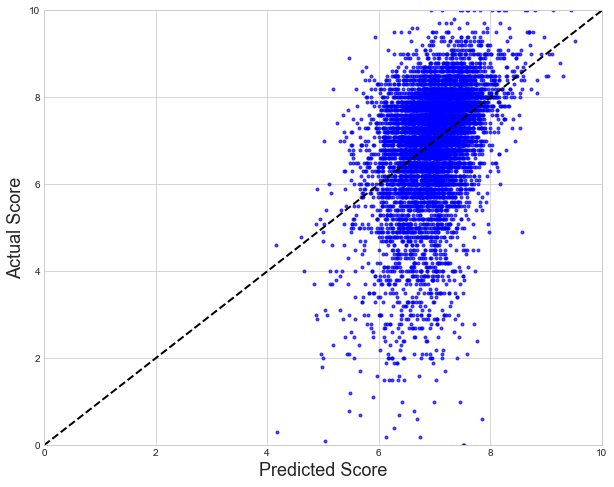

In [82]:
a = range(11)
b = range(11)

plt.figure(figsize=(10,8))
plt.scatter(df['predicted_score'], df['score'], marker='.', alpha=0.7, color='blue')
plt.plot(a, b, 'r--', linewidth=2, color='black')
#plt.title('Model Performance', fontsize=18)
plt.ylabel('Actual Score', fontsize=18)
plt.xlabel('Predicted Score', fontsize=18)
plt.xlim(0, 10)
plt.ylim(0, 10)

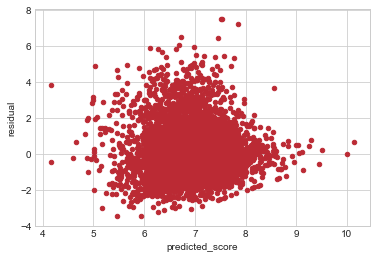

In [83]:
df.plot(kind='scatter', x='predicted_score', y='residual');